# Model Evaluation

This notebook lets you evaluate your trained model on train and test data. 

Date: 24-FEB-2020

In [55]:
import sys
sys.path.insert(0, "../src/")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [57]:
import torch
from tester import ModelTester
from data import CustomEvalDataset, default_test_transforms
from utils import resize_mask, overlay_image_and_mask

In [58]:
from models import VGG16Baseline, VGG16WithDecoderV2
from data import CCDataLoader, default_train_transforms, default_val_transforms, display_transforms
from debug import load_predict, plot_sample

# Data

In [59]:
# Load SHHA data
data_dir = {
    "train": "/mnt/bigdrive/datasets/crowd-counting/C3Data/train_data/",
    "val": "/mnt/bigdrive/datasets/crowd-counting/C3Data/test_data/"
}

output_size=224
loaders = {
    "train": CCDataLoader(
        data_dir["train"], default_train_transforms(output_size=output_size, factor=1), 
        num_workers=10
    ),
    "val": CCDataLoader(
        data_dir["val"], default_val_transforms(output_size=output_size, factor=1), 
        num_workers=10
    )
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
def mean_squared_error(true_labels, pred_labels):
    return np.sum((np.array(true_labels) - np.array(pred_labels))**2)/len(true_labels)

def mean_absolute_error(true_labels, pred_labels):
    return np.sum(np.abs((np.array(true_labels) - np.array(pred_labels))**2))/len(true_labels)

# Initialise Dataframe
df_metrics = pd.DataFrame(columns=["model","dataset","type","mse", "mae"])

# Baseline Model

In this notebook, we plot baseline model performance on SHHA and SHHB datasets. Note that model was only trained using training set from SHHA. 

In [61]:
checkpoint = torch.load("../src/ckpt/vggbaseline-1e-05-0.062620200426.pt")
model = VGG16Baseline(scale_factor=32) 
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [62]:
(true_labels, pred_labels) = load_predict(model, device, None, loaders["train"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vgg16baseline", "dataset": "SHHA", "type": "train", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)

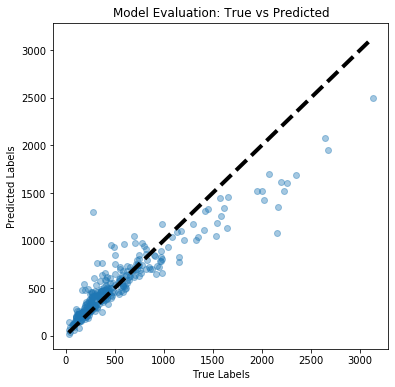

<Figure size 432x288 with 0 Axes>

In [63]:
plt = plot_sample(true_labels, pred_labels)
# plt = load_predict_plot(model, device, None, loaders["train"].ds.images)
plt.show()
plt.savefig("vgg16baseline-shha-train.png")

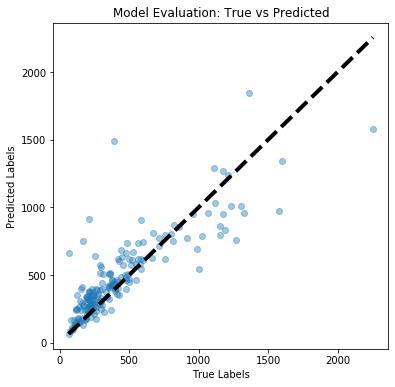

<Figure size 432x288 with 0 Axes>

In [64]:
# Let's check the performance on test data
(true_labels, pred_labels) = load_predict(model, device, None, loaders["val"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vgg16baseline", "dataset": "SHHA", "type": "test", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vgg16baseline-shha-val.png")

Now, let's see how does the model performs on SHHB dataset. 

In [65]:
# Load SHHB data
shhb_data_dir = {
    "train": "/mnt/bigdrive/datasets/crowd-counting/C3Data/shhb/train_data/",
    "val": "/mnt/bigdrive/datasets/crowd-counting/C3Data/shhb/test_data/"
}

output_size=224
shhb_loaders = {
    "train": CCDataLoader(
        shhb_data_dir["train"], default_train_transforms(output_size=output_size, factor=1), 
        num_workers=10
    ),
    "val": CCDataLoader(
        shhb_data_dir["val"], default_val_transforms(output_size=output_size, factor=1), 
        num_workers=10
    )
}

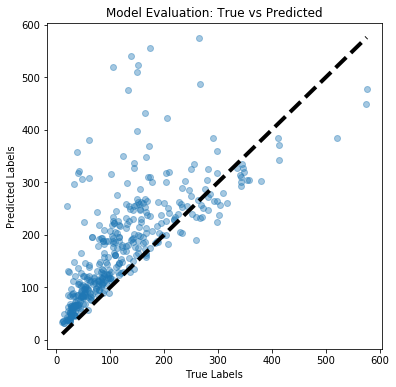

<Figure size 432x288 with 0 Axes>

In [66]:
# Training set
# plt = load_predict_plot(model, device, None, shhb_loaders["train"].ds.images)
# plt.savefig("vgg16decoder-shhb-train.png")
(true_labels, pred_labels) = load_predict(model, device, None, shhb_loaders["train"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vgg16baseline", "dataset": "SHHB", "type": "train", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vgg16baseline-shhb-train.png")

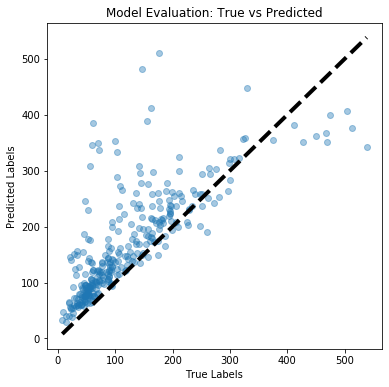

<Figure size 432x288 with 0 Axes>

In [67]:
# Test set
# plt = load_predict_plot(model, device, None, shhb_loaders["val"].ds.images)
# plt.savefig("vgg16decoder-shhb-val.png")
(true_labels, pred_labels) = load_predict(model, device, None, shhb_loaders["val"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vgg16baseline", "dataset": "SHHB", "type": "test", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vgg16baseline-shhb-val.png")

As you can see from the plots, the model does not do as well as it did on SHHA dataset. It seems to overestimate the crowd. There are a few things you could try:
* Get more data: combine training set from both the datasets
* Experiment with model architecture

# VGG16 With Decoder

Next, we evaluate the VGG16WithDecoderV2 model and see how it performs

In [68]:
checkpoint = torch.load("../src/ckpt/vggdecoder-1e-05-0.057920200427.pt")
model = VGG16WithDecoderV2() 
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

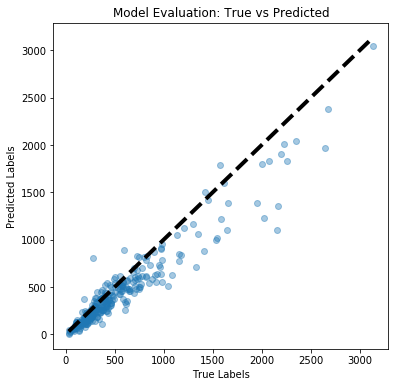

<Figure size 432x288 with 0 Axes>

In [69]:
(true_labels, pred_labels) = load_predict(model, device, None, loaders["train"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vggdecoder", "dataset": "SHHA", "type": "train", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vggdecoder-shha-train.png")

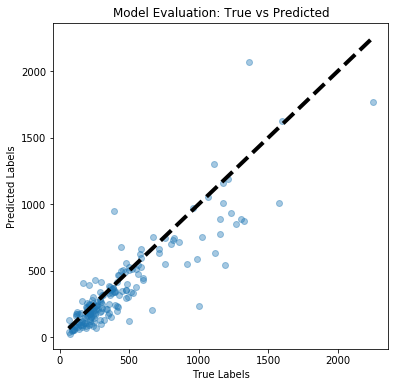

<Figure size 432x288 with 0 Axes>

In [70]:
(true_labels, pred_labels) = load_predict(model, device, None, loaders["val"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vggdecoder", "dataset": "SHHA", "type": "val", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vggdecoder-shha-val.png")

## SHHB dataset

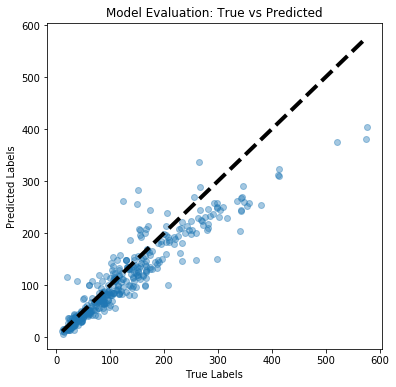

<Figure size 432x288 with 0 Axes>

In [71]:
(true_labels, pred_labels) = load_predict(model, device, None, shhb_loaders["train"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vggdecoder", "dataset": "SHHB", "type": "train", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vggdecoder-shhb-train.png")

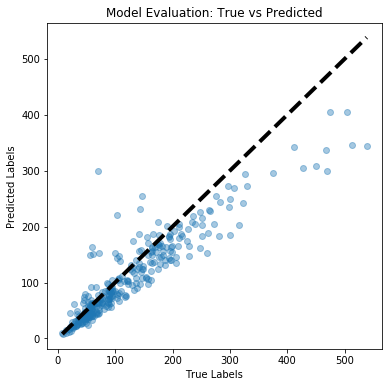

<Figure size 432x288 with 0 Axes>

In [72]:
(true_labels, pred_labels) = load_predict(model, device, None, shhb_loaders["val"].ds.images)
df_metrics = df_metrics.append(
    {"model": "vggdecoder", "dataset": "SHHB", "type": "val", 
     "mse":mean_squared_error(true_labels, pred_labels), 
     "mae": mean_absolute_error(true_labels, pred_labels),
    },
    ignore_index=True
)
plt = plot_sample(true_labels, pred_labels)
plt.show()
plt.savefig("vggdecoder-shhb-val.png")

# Conclusions

Comparing the plots generated by VGG Baseline and Decoder, we notice that decoder model is able to generalise better among the two and has a lot more points near the diagonal line.

> 👔: Plots are fine, but why don't you quantify it?

> Me: Plots above give you a better idea of how the model performs

> 👔: Single Number. Why you no show me?

> Me: erm, here you go 👇

In [75]:
df_metrics

,model,dataset,type,mse,mae
0,vgg16baseline,SHHA,train,41088.746667,41088.746667
1,vgg16baseline,SHHA,test,36963.978022,36963.978022
2,vgg16baseline,SHHB,train,8585.027500,8585.027500
3,vgg16baseline,SHHB,test,6068.987342,6068.987342
4,vggdecoder,SHHA,train,34344.590000,34344.590000
5,vggdecoder,SHHA,val,30989.153846,30989.153846
6,vggdecoder,SHHB,train,1465.062500,1465.062500
7,vggdecoder,SHHB,val,1709.996835,1709.996835


In [76]:
df_metrics.to_csv("full-v1-metrics.csv")